Sentimenatl Analysis - Hotel Review
* Bidirectional GRU model 
* applying lemmatization technique contributes to better prediction?  
* applying stemmming technique contributes to better prediction?

In [1]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve 
from sklearn.metrics import roc_curve, classification_report, f1_score, roc_auc_score
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras

from nltk.stem import PorterStemmer, WordNetLemmatizer
from keras.layers import Embedding, Dense, LSTM, Bidirectional, TextVectorization
from keras.layers import Flatten, GRU, Dropout, SimpleRNN,SpatialDropout1D, GlobalAveragePooling1D
from keras import Input, Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import plot_model

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Read Data

* Data Source - [Trip Advisor Hotel Reviews](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews)

In [4]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv',engine='python')
df.shape

(20491, 2)

## Label Review Rating


*   0 if rating is 1 or 2 or 3
*   1 if rating is 4 or 5

In [5]:
df['Rating'].value_counts()
df['label'] = np.array(df['Rating'].apply(lambda x: 1 if x > 3 else 0))
df.head()

,Review,Rating,label
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


Class Label Imbalance


In [6]:
pos,neg = np.bincount(df['label'])
total=neg+pos
print('Total:{}\n  Positive:{} ({:.2f}% of total)\n'.format(total, pos, 100*(pos/total)))

Total:20491
  Positive:5398 (26.34% of total)



In [7]:
pos

5398

In [8]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.02820255])

## Preprocessing Review Text


*   remove integer values
*   breakdown to words by space delimiter 
*   remove stopwords using nltk library
*   apply Lemmartization 
*   apply Stemming 

In [9]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
nltk.download('wordnet')  # for Lemmartization
nltk.download('omw-1.4')  # for Lemmartization
nltk.download('punkt')         # for Stemming

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
lema = WordNetLemmatizer()
pstm = PorterStemmer()
def preprocess1(text):
    text = re.sub(r'[^a-zA-Z]',' ',text)
    text = text.split()
    text = ' '.join([w for w in text if not w.lower().strip() in stop_words])
    return text

def preprocess2(text):
    text = re.sub(r'[^a-zA-Z]',' ',text)
    text = text.split()
    text = [w for w in text if not w.lower().strip() in stop_words]
    text = ' '.join([lema.lemmatize(w) for w in text])
    return text

def preprocess3(text):
    text = re.sub(r'[^a-zA-Z]',' ',text)
    text = text.split()
    text = [w for w in text if not w.lower().strip() in stop_words]
    text = ' '.join([pstm.stem(w) for w in text])
    return text

In [11]:
df['proc_review1'] = df['Review'].apply(preprocess1)
df['proc_review2'] = df['Review'].apply(preprocess2)
df['proc_review3'] = df['Review'].apply(preprocess3)

## Training and Testing Data Split

> Split data into train and test datasets with equal proportion of label.

In [12]:

X_train1, X_test1, y_train1, y_test1 = train_test_split(df['proc_review1'].values,df['label'].values,
                                                    test_size=0.2, random_state=1,stratify=df['label'].values)



X_train2, X_test2, y_train2, y_test2 = train_test_split(df['proc_review2'].values,df['label'].values,
                                                    test_size=0.2, random_state=1,stratify=df['label'].values)


X_train3, X_test3, y_train3, y_test3 = train_test_split(df['proc_review3'].values,df['label'].values,
                                                    test_size=0.2, random_state=1,stratify=df['label'].values)

## Tokenization

*   convert to lower case (default)
*   remove punctuation
*   integer encoding to word - map each word with unique index for each word with most common as 1 to least common xxx
*   sequence encoding to review
*   NOTE: require data to be str format

AVOID Data Leakage
*  build tokenizer using only training data





In [13]:
NWORDS = 10000
tknz1 = Tokenizer(num_words=NWORDS,oov_token ="_OOV")
tknz1.fit_on_texts(X_train1)

train_seq1 = tknz1.texts_to_sequences(X_train1)
test_seq1 = tknz1.texts_to_sequences(X_test1)

tknz2 = Tokenizer(num_words=NWORDS,oov_token ="_OOV")
tknz2.fit_on_texts(X_train2)

train_seq2 = tknz2.texts_to_sequences(X_train2)
test_seq2 = tknz2.texts_to_sequences(X_test2)

tknz3 = Tokenizer(num_words=NWORDS,oov_token ="_OOV")
tknz3.fit_on_texts(X_train3)

train_seq3 = tknz3.texts_to_sequences(X_train3)
test_seq3 = tknz3.texts_to_sequences(X_test3)

Lemmartization and Stemming reduces the total word_index count.  

In [14]:
print(len(tknz1.word_index))
print(len(tknz2.word_index))
print(len(tknz3.word_index))

43674
39814
31703


## Padding
*   get the length of longest review text 
*   set all sequences to a uniform length with the longest review length by filling in with 0 
*   padding flag 'pre': pad 0 in the beginning
*   padding flag 'post': pad 0 in the end



In [15]:
print(np.max(list(map(lambda x: len(x), train_seq1)))+1)
print(np.max(list(map(lambda x: len(x), train_seq2)))+1)
print(np.max(list(map(lambda x: len(x), train_seq3)))+1)
MAX_SEQ_LEN =np.max(list(map(lambda x: len(x), train_seq1)))+1


1890
1890
1890


In [16]:
pad_train_seq1 = pad_sequences(train_seq1,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')
pad_test_seq1 = pad_sequences(test_seq1,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')

pad_train_seq2 = pad_sequences(train_seq2,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')
pad_test_seq2 = pad_sequences(test_seq2,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')

pad_train_seq3 = pad_sequences(train_seq3,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')
pad_test_seq3 = pad_sequences(test_seq3,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')


## Build Model

In [17]:
EMBED_DIM = 32
BATCH_SIZE = 1000
EPOCH = 30

In [18]:
def show_model_summary(model):
  print()
  print(model.summary())
  print()

In [19]:
def build_BiGRU(embedding_dim,max_seq_len,output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS, output_dim=embedding_dim,
                      input_length=max_seq_len))
  model.add(Dropout(0.5))
  model.add(Bidirectional(GRU(32,return_sequences=True)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid',bias_initializer=output_bias))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
            metrics = ['accuracy',
                       tf.keras.metrics.AUC(name='AUC'),
                       keras.metrics.AUC(name='PRC', curve='PR')])
  
  return model

In [20]:
def fit_model(model, model_name,X,y):
  history = model.fit(X,y,
                    validation_split=0.2,
                    batch_size=BATCH_SIZE,epochs=EPOCH,
                    verbose=2,
                    callbacks=[
                            EarlyStopping(
                            monitor='val_PRC',
                            patience=3,
                            mode = 'max',
                            restore_best_weights=True
                        )
                        
                    ]
                   )
  model.save(model_name)
  print(pd.DataFrame(model.history.history))
  return history

In [21]:
def plot_metrics(history):
  metrics = ['loss', 'PRC', 'AUC', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'AUC':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1890, 32)          320000    
                                                                 
 dropout (Dropout)           (None, 1890, 32)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1890, 64)         12672     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 1890, 64)          0         
                                                                 
 flatten (Flatten)           (None, 120960)            0         
                                                                 
 dense (Dense)               (None, 1)                 120961    
                                                       

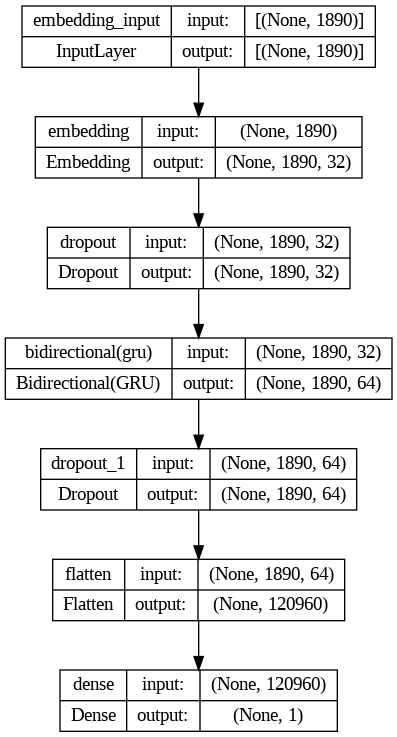

In [22]:
grumodel1 = build_BiGRU(EMBED_DIM,MAX_SEQ_LEN)
grumodel2 = build_BiGRU(EMBED_DIM,MAX_SEQ_LEN)
grumodel3 = build_BiGRU(EMBED_DIM,MAX_SEQ_LEN)

show_model_summary(grumodel1)
plot_model(grumodel1,show_shapes=True)

In [23]:
def test_eval(clf_model, testX, testy):
    # Test set prediction
    y_pred=clf_model.predict(testX)
    y_predict = []
    for p in y_pred:
        if p > 0.5:
            y_predict.append(1)
        else:
            y_predict.append(0)
    print('Confusion Matrix')
    print('='*60)
    cm = confusion_matrix(testy,y_predict)
    print(cm,"\n")
    print('Classification Report')
    print('='*60)
    cr = classification_report(testy,y_predict)
    print(cr,"\n")
    
    return cm,cr,y_predict

Epoch 1/30
14/14 - 228s - loss: 0.6088 - accuracy: 0.6981 - AUC: 0.5174 - PRC: 0.7450 - val_loss: 0.5679 - val_accuracy: 0.7496 - val_AUC: 0.6363 - val_PRC: 0.8340 - 228s/epoch - 16s/step
Epoch 2/30
14/14 - 208s - loss: 0.5634 - accuracy: 0.7325 - AUC: 0.6308 - PRC: 0.8178 - val_loss: 0.5165 - val_accuracy: 0.7508 - val_AUC: 0.7715 - val_PRC: 0.9066 - 208s/epoch - 15s/step
Epoch 3/30
14/14 - 207s - loss: 0.4929 - accuracy: 0.7566 - AUC: 0.8208 - PRC: 0.9210 - val_loss: 0.4032 - val_accuracy: 0.8134 - val_AUC: 0.8968 - val_PRC: 0.9615 - 207s/epoch - 15s/step
Epoch 4/30
14/14 - 223s - loss: 0.3468 - accuracy: 0.8556 - AUC: 0.9151 - PRC: 0.9626 - val_loss: 0.2777 - val_accuracy: 0.8878 - val_AUC: 0.9361 - val_PRC: 0.9738 - 223s/epoch - 16s/step
Epoch 5/30
14/14 - 208s - loss: 0.2487 - accuracy: 0.8996 - AUC: 0.9462 - PRC: 0.9768 - val_loss: 0.2394 - val_accuracy: 0.8984 - val_AUC: 0.9512 - val_PRC: 0.9809 - 208s/epoch - 15s/step
Epoch 6/30
14/14 - 209s - loss: 0.1985 - accuracy: 0.9222 - 

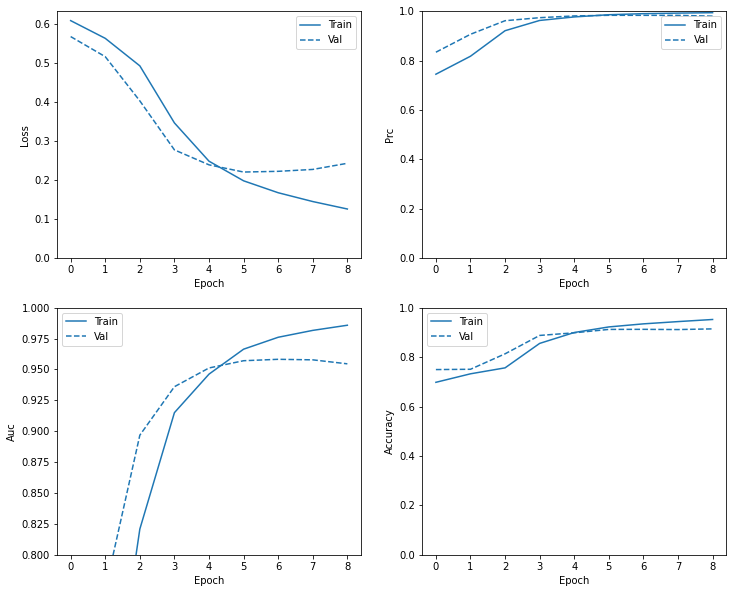

In [24]:
gruhistory1 = fit_model(grumodel1,'./saved_model/grumodel1.h5',pad_train_seq1,y_train1)

plot_metrics(gruhistory1)
gru_results1 = grumodel1.evaluate(pad_test_seq1,y_test1,verbose=2)


In [25]:
cm1,cr1,_  = test_eval(grumodel1,pad_test_seq1,y_test1)
fpr1, tpr1, thresh1 = roc_curve(y_test1, grumodel1.predict(pad_test_seq1))
precision1, recall1, _ = precision_recall_curve(y_test1, grumodel1.predict(pad_test_seq1))

129/129 [==============================] - 35s 262ms/step
Confusion Matrix
[[ 825  255]
 [ 192 2827]] 

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1080
           1       0.92      0.94      0.93      3019

    accuracy                           0.89      4099
   macro avg       0.86      0.85      0.86      4099
weighted avg       0.89      0.89      0.89      4099
 

129/129 [==============================] - 34s 264ms/step


Epoch 1/30
14/14 - 212s - loss: 0.6202 - accuracy: 0.7329 - AUC: 0.5085 - PRC: 0.7401 - val_loss: 0.5616 - val_accuracy: 0.7511 - val_AUC: 0.6214 - val_PRC: 0.8267 - 212s/epoch - 15s/step
Epoch 2/30
14/14 - 204s - loss: 0.5736 - accuracy: 0.7330 - AUC: 0.5737 - PRC: 0.7879 - val_loss: 0.5437 - val_accuracy: 0.7511 - val_AUC: 0.7390 - val_PRC: 0.8927 - 204s/epoch - 15s/step
Epoch 3/30
14/14 - 205s - loss: 0.5317 - accuracy: 0.7347 - AUC: 0.7683 - PRC: 0.8965 - val_loss: 0.4750 - val_accuracy: 0.7920 - val_AUC: 0.8765 - val_PRC: 0.9542 - 205s/epoch - 15s/step
Epoch 4/30
14/14 - 206s - loss: 0.4189 - accuracy: 0.8113 - AUC: 0.8940 - PRC: 0.9552 - val_loss: 0.3229 - val_accuracy: 0.8710 - val_AUC: 0.9283 - val_PRC: 0.9727 - 206s/epoch - 15s/step
Epoch 5/30
14/14 - 206s - loss: 0.2868 - accuracy: 0.8866 - AUC: 0.9329 - PRC: 0.9705 - val_loss: 0.2563 - val_accuracy: 0.8951 - val_AUC: 0.9417 - val_PRC: 0.9764 - 206s/epoch - 15s/step
Epoch 6/30
14/14 - 205s - loss: 0.2264 - accuracy: 0.9102 - 

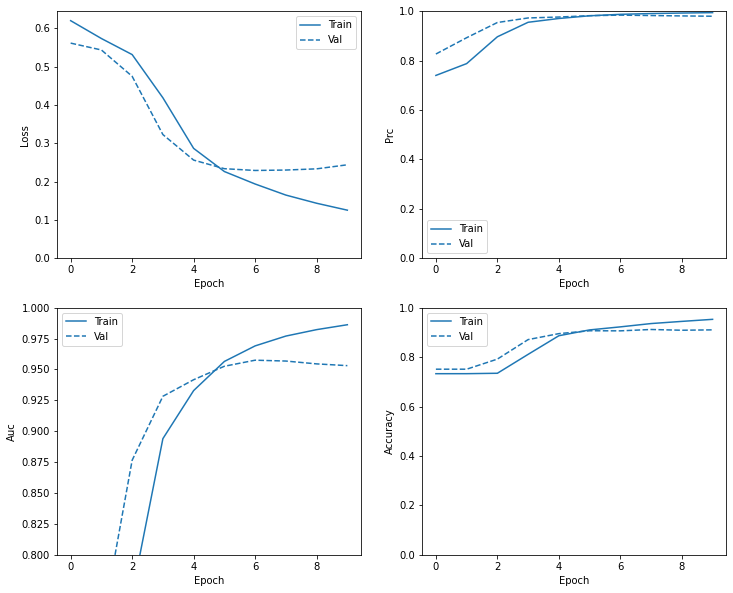

In [26]:
gruhistory2 = fit_model(grumodel2,'./saved_model/grumodel2_lem.h5',pad_train_seq2,y_train2)
plot_metrics(gruhistory2)
gru_results2 = grumodel2.evaluate(pad_test_seq2,y_test2,verbose=2)


In [27]:
cm2,cr2,_  = test_eval(grumodel2,pad_test_seq2,y_test2)
fpr2, tpr2, thresh2 = roc_curve(y_test2, grumodel2.predict(pad_test_seq2))
precision2, recall2, _ = precision_recall_curve(y_test2, grumodel2.predict(pad_test_seq2))

129/129 [==============================] - 35s 267ms/step
Confusion Matrix
[[ 869  211]
 [ 247 2772]] 

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1080
           1       0.93      0.92      0.92      3019

    accuracy                           0.89      4099
   macro avg       0.85      0.86      0.86      4099
weighted avg       0.89      0.89      0.89      4099
 

129/129 [==============================] - 34s 263ms/step


Epoch 1/30
14/14 - 221s - loss: 0.5982 - accuracy: 0.7329 - AUC: 0.5093 - PRC: 0.7404 - val_loss: 0.5723 - val_accuracy: 0.7511 - val_AUC: 0.6362 - val_PRC: 0.8317 - 221s/epoch - 16s/step
Epoch 2/30
14/14 - 215s - loss: 0.5662 - accuracy: 0.7330 - AUC: 0.6165 - PRC: 0.8119 - val_loss: 0.5252 - val_accuracy: 0.7511 - val_AUC: 0.7561 - val_PRC: 0.8974 - 215s/epoch - 15s/step
Epoch 3/30
14/14 - 224s - loss: 0.5029 - accuracy: 0.7501 - AUC: 0.8076 - PRC: 0.9149 - val_loss: 0.4134 - val_accuracy: 0.8219 - val_AUC: 0.8872 - val_PRC: 0.9581 - 224s/epoch - 16s/step
Epoch 4/30
14/14 - 219s - loss: 0.3538 - accuracy: 0.8511 - AUC: 0.9108 - PRC: 0.9599 - val_loss: 0.2809 - val_accuracy: 0.8884 - val_AUC: 0.9291 - val_PRC: 0.9703 - 219s/epoch - 16s/step
Epoch 5/30
14/14 - 225s - loss: 0.2617 - accuracy: 0.8945 - AUC: 0.9412 - PRC: 0.9744 - val_loss: 0.2488 - val_accuracy: 0.8975 - val_AUC: 0.9481 - val_PRC: 0.9786 - 225s/epoch - 16s/step
Epoch 6/30
14/14 - 222s - loss: 0.2118 - accuracy: 0.9176 - 

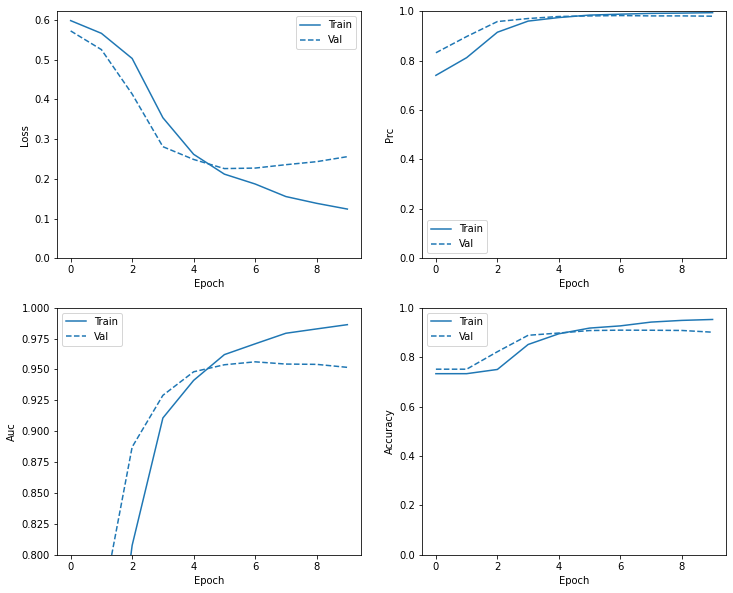

In [28]:
gruhistory3 = fit_model(grumodel3,'./saved_model/grumodel2_ps.h5',pad_train_seq3,y_train3)
plot_metrics(gruhistory3)
gru_results3 = grumodel3.evaluate(pad_test_seq3,y_test3,verbose=2)

In [34]:
cm3,cr3,_  = test_eval(grumodel3,pad_test_seq3,y_test3)
fpr3, tpr3, thresh3 = roc_curve(y_test3, grumodel3.predict(pad_test_seq3))
precision3, recall3, _ = precision_recall_curve(y_test3, grumodel3.predict(pad_test_seq3))

129/129 [==============================] - 38s 294ms/step
Confusion Matrix
[[ 849  231]
 [ 200 2819]] 

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1080
           1       0.92      0.93      0.93      3019

    accuracy                           0.89      4099
   macro avg       0.87      0.86      0.86      4099
weighted avg       0.89      0.89      0.89      4099
 

129/129 [==============================] - 35s 273ms/step


# Performance Comparison using Evaluation Metrics

* Accuracy
* F1-Score
* Precision
* Recall
* PRC

In [35]:
print("Bidirectional GRU")
print(gru_results1)
print("Lemmartization + Bidirectional GRU")
print(gru_results2)
print("Stemming + Bidirectional GRU")
print(gru_results3)

Bidirectional GRU
[0.2711033523082733, 0.890949010848999, 0.9385102987289429, 0.9732563495635986]
Lemmartization + Bidirectional GRU
[0.2761748135089874, 0.8882654309272766, 0.9393276572227478, 0.9746898412704468]
Stemming + Bidirectional GRU
[0.27430495619773865, 0.8948523998260498, 0.942381739616394, 0.9748847484588623]


In [36]:
def plot_cmatrix(cmatrix, name):
    fig = px.imshow(cmatrix,color_continuous_scale=[[0.0, 'peachpuff'], 
                                          [0.5, 'lime'], 
                                          [1.0, 'green']])

    fig.update_layout(
        title = 'Confusion Matrix ('+ name + ')', title_x=0.5,
        xaxis_title="Predicted Label", yaxis_title="Actual Label", 
        height=400,
        width=400,
        xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1),
        yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1)
    )
    for i in range(len(cmatrix)):
        for j in range(len(cmatrix[0])):
            fig.add_annotation(
                x=j,
                y=i,
                text=str(cmatrix[i,j]),
                showarrow=False,
                font_size=9, font_color='black'
            )

    fig.show()

In [37]:
plot_cmatrix(cm1, name='BiGRU')

plot_cmatrix(cm2, name='Lemmartization + BiGRU')

plot_cmatrix(cm2, name='Stemming + BiGRU')

In [38]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=recall1,y=precision1,mode='lines',name='Bidirectional GRU'))
fig.add_trace(go.Scatter(x=recall2,y=precision2,mode='lines',name='Bidirectional GRU with Lemmartization'))
fig.add_trace(go.Scatter(x=recall3,y=precision3,mode='lines',name='Bidirectional GRU with Stemming'))
fig.update_layout(title='Precision-Recall Curve',
                   xaxis_title='Recall',
                   yaxis_title='Precision', title_x = 0.5,
                   width = 800, height=450,
                 )
fig.show()



# Summary
* Since this is an imbalance dataset problem - F1-score and the PRC(Precision Recall Curve) metrics are considered for model performance evaluation metrics.  
* For the given problem - apply Lemmartization or Stemming doesn't significantly improve the model prediction performance.   

